# Titanic Survival Prediction

## 1. Import Libraries and Load Data

First, let's import the necessary libraries and load our training and testing datasets.

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
display(train_df.head())


Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Exploratory Data Analysis (EDA)

Now, let's explore the data to understand its structure, find patterns, and identify missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Valeurs manquantes :
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked     

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


/tmp/ipykernel_41452/4165020929.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=train_df, palette='Set2')


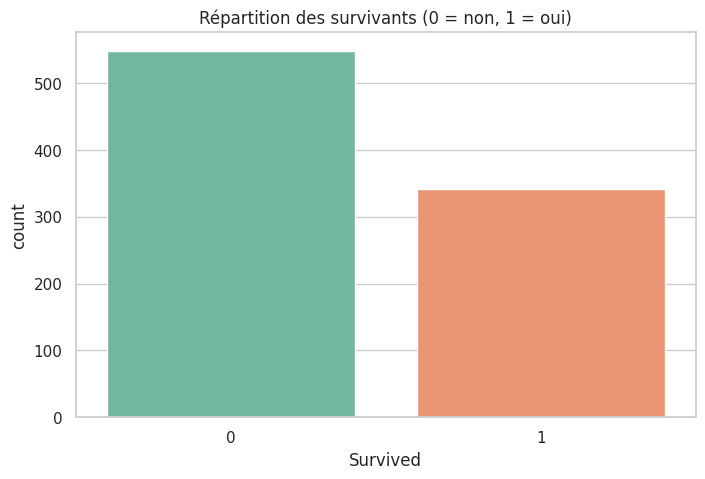

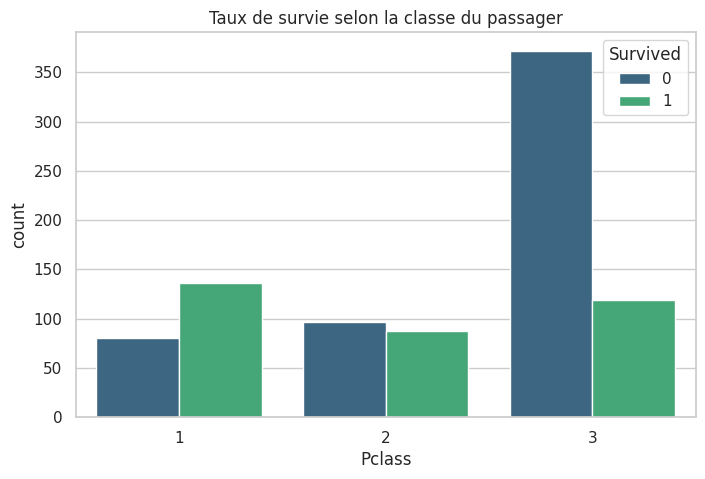

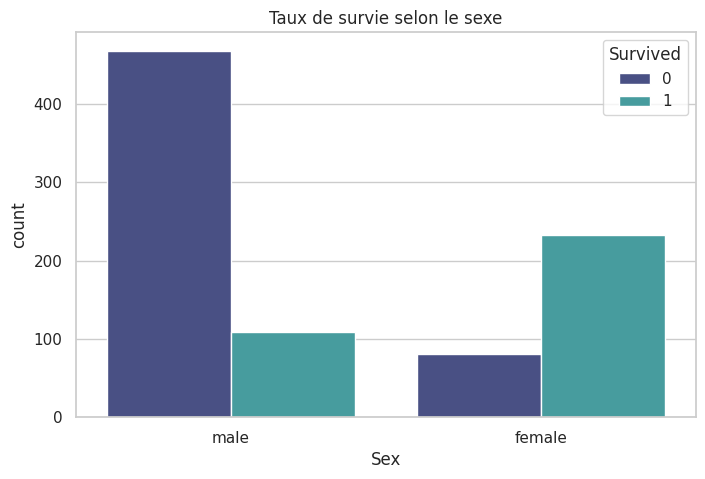

In [2]:

train_df.info()
print("\nValeurs manquantes :")
print(train_df.isnull().sum())

display(train_df.describe())

sns.countplot(x='Survived', data=train_df, palette='Set2')
plt.title("Répartition des survivants (0 = non, 1 = oui)")
plt.show()

sns.countplot(x='Pclass', hue='Survived', data=train_df, palette='viridis')
plt.title("Taux de survie selon la classe du passager")
plt.show()

sns.countplot(x='Sex', hue='Survived', data=train_df, palette='mako')
plt.title("Taux de survie selon le sexe")
plt.show()


## 3. Data Cleaning & Feature Engineering

Based on our EDA, we'll clean the data by handling missing values and create new features to improve our model's performance.

In [5]:
# === BLOC 3 : NETTOYAGE & FEATURE ENGINEERING (corrigé) ===

# 1️⃣ Gestion des valeurs manquantes
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# 2️⃣ Extraction du titre
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.')
test_df['Title']  = test_df['Name'].str.extract(' ([A-Za-z]+)\.')

# 3️⃣ Regroupement cohérent des titres
title_mapping = {
    'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
    'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare', 'Mlle': 'Miss',
    'Ms': 'Miss', 'Countess': 'Rare', 'Lady': 'Rare', 'Jonkheer': 'Rare',
    'Don': 'Rare', 'Sir': 'Rare', 'Dona': 'Rare', 'Capt': 'Rare'
}

train_df['Title'] = train_df['Title'].map(title_mapping)
test_df['Title']  = test_df['Title'].map(title_mapping)

# Vérification : si certains titres n'ont pas été mappés, on les remplace par "Rare"
train_df['Title'].fillna('Rare', inplace=True)
test_df['Title'].fillna('Rare', inplace=True)

# 4️⃣ Encodage des variables catégorielles
label = LabelEncoder()
for col in ['Sex', 'Embarked', 'Title']:
    all_values = pd.concat([train_df[col], test_df[col]])  # inclut les deux datasets
    label.fit(all_values)
    train_df[col] = label.transform(train_df[col])
    test_df[col] = label.transform(test_df[col])

# 5️⃣ Nouvelles features
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize']  = test_df['SibSp'] + test_df['Parch'] + 1

train_df['IsAlone'] = np.where(train_df['FamilySize'] == 1, 1, 0)
test_df['IsAlone']  = np.where(test_df['FamilySize'] == 1, 1, 0)

# 6️⃣ Suppression des colonnes inutiles
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df.drop(columns=cols_to_drop, inplace=True)
test_passenger_ids = test_df['PassengerId']
test_df.drop(columns=cols_to_drop, inplace=True)

print("✅ Données nettoyées et cohérentes entre train et test.")
display(train_df.head())


✅ Données nettoyées et cohérentes entre train et test.


<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_41452/2204336082.py:10: SyntaxWarning: invalid escape sequence '\.'
  train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.')
/tmp/ipykernel_41452/2204336082.py:11: SyntaxWarning: invalid escape sequence '\.'
  test_df['Title']  = test_df['Name'].str.extract(' ([A-Za-z]+)\.')
/tmp/ipykernel_41452/2204336082.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,1,22.0,1,0,7.2500,2,2,2,0
1,1,1,0,38.0,1,0,71.2833,0,3,2,0
2,1,3,0,26.0,0,0,7.9250,2,1,1,1
3,1,1,0,35.0,1,0,53.1000,2,3,2,0
4,0,3,1,35.0,0,0,8.0500,2,2,1,1


## 4. Model Training and Evaluation

It's time to choose a model, train it on our processed data, and see how well it performs.

Accuracy: 0.827

Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       105
           1       0.82      0.74      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



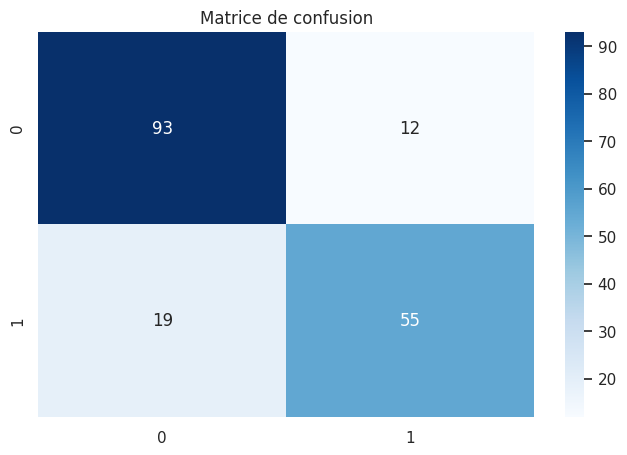

/tmp/ipykernel_41452/2501842469.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="crest")


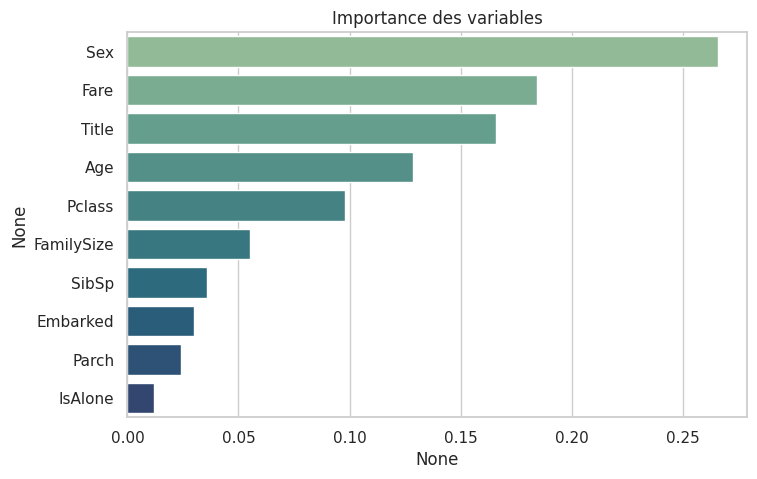

In [6]:

X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_df)


rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_val_scaled)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.3f}")
print("\nRapport de classification :\n", classification_report(y_val, y_pred))

sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index, palette="crest")
plt.title("Importance des variables")
plt.show()


## 5. Create Submission File

Finally, we'll use our trained model to make predictions on the test set and generate the submission file in the required format.

In [7]:

predictions = rf_model.predict(test_scaled)

submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": predictions
})

submission.to_csv("submission.csv", index=False)
print("✅ Fichier 'submission.csv' généré avec succès !")
display(submission.head())

!python run_test.py


✅ Fichier 'submission.csv' généré avec succès !


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


--- Checking submission.csv ---
✅ Header is correct.
✅ All rows have the correct format and values.
✅ Correct number of rows (418).

🎉 Success! Your submission file passed all sanity checks.
